<a href="https://colab.research.google.com/github/UBGidado/My_Research/blob/main/Correlation_%26_Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsmodels --quiet

## imports

In [2]:
import torch
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.inter_rater import fleiss_kappa
from scipy.stats import pearsonr

# Correlation Analysis and Visualization

#### Data Loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

triples_df = pd.read_csv('/content/drive/MyDrive/My Research/triples_df.csv')
display(triples_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,text_id,context,relationship,verb,verb_cluster,verb_cluster_label,normalized_subject,normalized_object,subject_vec,object_vec,subject_cluster,object_cluster,subject_cluster_label,object_cluster_label,Dominant Distortion,Secondary Distortion (Optional)
0,0,1,Nobody likes me because I'm not interesting.,"('like', ' Nobody', 'me')",like,2,Positive Affect / Affection,nobody,I,[-1.8909e-01 6.1590e-02 -2.0150e-01 -3.3876e-...,[ 1.8733e-01 4.0595e-01 -5.1174e-01 -5.5482e-...,0,0,Self & Others (Human Agents),Human Targets,NaN,NaN
1,1,10,My partner didn't say 'I love you' today our ...,"('love', 'I', 'you')",love,2,Positive Affect / Affection,I,you,[ 1.8733e-01 4.0595e-01 -5.1174e-01 -5.5482e-...,[-1.1076e-01 3.0786e-01 -5.1980e-01 3.5138e-...,0,0,Self & Others (Human Agents),Human Targets,NaN,NaN
2,2,12,I didn't get a reply to my email they must ha...,"('hate', 'they', 'me')",hate,0,Negative Affect / Conflict Emotion,they,I,[-1.3889e-01 1.0991e-01 -2.0471e-01 -3.2585e-...,[ 1.8733e-01 4.0595e-01 -5.1174e-01 -5.5482e-...,0,0,Self & Others (Human Agents),Human Targets,NaN,NaN
3,3,23,No one will ever love me because I'm too shy.,"('love', ' No one', 'me')",love,2,Positive Affect / Affection,no one,I,[-4.35695015e-02 7.28705004e-02 -2.94284999e-...,[ 1.8733e-01 4.0595e-01 -5.1174e-01 -5.5482e-...,0,0,Self & Others (Human Agents),Human Targets,NaN,NaN
4,4,39,My boss criticized my report she thinks I'm n...,"('criticize', ' My boss', 'my report')",criticize,0,Negative Affect / Conflict Emotion,my boss,my report,[-1.63764998e-01 1.51140004e-01 -3.30550015e-...,[-3.87760013e-01 2.10770011e-01 -3.01145017e-...,0,0,Self & Others (Human Agents),Human Targets,NaN,NaN


In [4]:
triples_df.columns

Index(['id', 'text_id', 'context', 'relationship', 'verb', 'verb_cluster',
       'verb_cluster_label', 'normalized_subject', 'normalized_object',
       'subject_vec', 'object_vec', 'subject_cluster', 'object_cluster',
       'subject_cluster_label', 'object_cluster_label', 'Dominant Distortion',
       'Secondary Distortion (Optional)'],
      dtype='object')

#### Feature Encoding

In [5]:
triples_df["Dominant Distortion"] = triples_df["Dominant Distortion"].fillna("No Distortion").astype(str)

# Encoding Dominant Distortion as categorical integer
distortion_encoder = LabelEncoder()
triples_df["distortion_encoded"] = distortion_encoder.fit_transform(triples_df["Dominant Distortion"])

# One-hot encoding for visualizing as matrix
onehot = pd.get_dummies(triples_df["Dominant Distortion"])
triples_df = pd.concat([triples_df, onehot], axis=1)

print("Encoded distortions:", distortion_encoder.classes_)

Encoded distortions: ['All-or-nothing thinking' 'Emotional Reasoning' 'Fortune-telling'
 'Labeling' 'Magnification' 'Mental filter' 'Mind Reading' 'No Distortion'
 'Overgeneralization' 'Personalization' 'Should statements']


#### Co-occurrence Matrices & Heatmaps

In [6]:
triples_df = pd.read_csv('/content/drive/MyDrive/My Research/triples_df.csv')

# Define the cluster labels
verb_cluster_labels = {
    0: "Negative Affect / Conflict Emotion",
    1: "Supportive Actions",
    2: "Positive Affect / Affection",
    3: "Interpersonal Beliefs / Roles",
    4: "Social Attachment & Rejection"
}

subject_cluster_labels = {
    0: "Self & Others (Human Agents)",
    1: "Parsing Errors / Noise",
    2: "Specific Actions"
}

object_cluster_labels = {
    0: "Human Targets",
    1: "Malformed Text / Noise",
    2: "Psychological/Condition Terms"
}

# Map the integer clusters to the labels
triples_df['verb_cluster_label'] = triples_df['verb_cluster'].map(verb_cluster_labels)
triples_df['subject_cluster_label'] = triples_df['subject_cluster'].map(subject_cluster_labels)
triples_df['object_cluster_label'] = triples_df['object_cluster'].map(object_cluster_labels)

display(triples_df.head())

,id,text_id,context,relationship,verb,verb_cluster,verb_cluster_label,normalized_subject,normalized_object,subject_vec,object_vec,subject_cluster,object_cluster,subject_cluster_label,object_cluster_label,Dominant Distortion,Secondary Distortion (Optional)
0,0,1,Nobody likes me because I'm not interesting.,"('like', ' Nobody', 'me')",like,2,Positive Affect / Affection,nobody,I,[-1.8909e-01 6.1590e-02 -2.0150e-01 -3.3876e-...,[ 1.8733e-01 4.0595e-01 -5.1174e-01 -5.5482e-...,0,0,Self & Others (Human Agents),Human Targets,NaN,NaN
1,1,10,My partner didn't say 'I love you' today our ...,"('love', 'I', 'you')",love,2,Positive Affect / Affection,I,you,[ 1.8733e-01 4.0595e-01 -5.1174e-01 -5.5482e-...,[-1.1076e-01 3.0786e-01 -5.1980e-01 3.5138e-...,0,0,Self & Others (Human Agents),Human Targets,NaN,NaN
2,2,12,I didn't get a reply to my email they must ha...,"('hate', 'they', 'me')",hate,0,Negative Affect / Conflict Emotion,they,I,[-1.3889e-01 1.0991e-01 -2.0471e-01 -3.2585e-...,[ 1.8733e-01 4.0595e-01 -5.1174e-01 -5.5482e-...,0,0,Self & Others (Human Agents),Human Targets,NaN,NaN
3,3,23,No one will ever love me because I'm too shy.,"('love', ' No one', 'me')",love,2,Positive Affect / Affection,no one,I,[-4.35695015e-02 7.28705004e-02 -2.94284999e-...,[ 1.8733e-01 4.0595e-01 -5.1174e-01 -5.5482e-...,0,0,Self & Others (Human Agents),Human Targets,NaN,NaN
4,4,39,My boss criticized my report she thinks I'm n...,"('criticize', ' My boss', 'my report')",criticize,0,Negative Affect / Conflict Emotion,my boss,my report,[-1.63764998e-01 1.51140004e-01 -3.30550015e-...,[-3.87760013e-01 2.10770011e-01 -3.01145017e-...,0,0,Self & Others (Human Agents),Human Targets,NaN,NaN


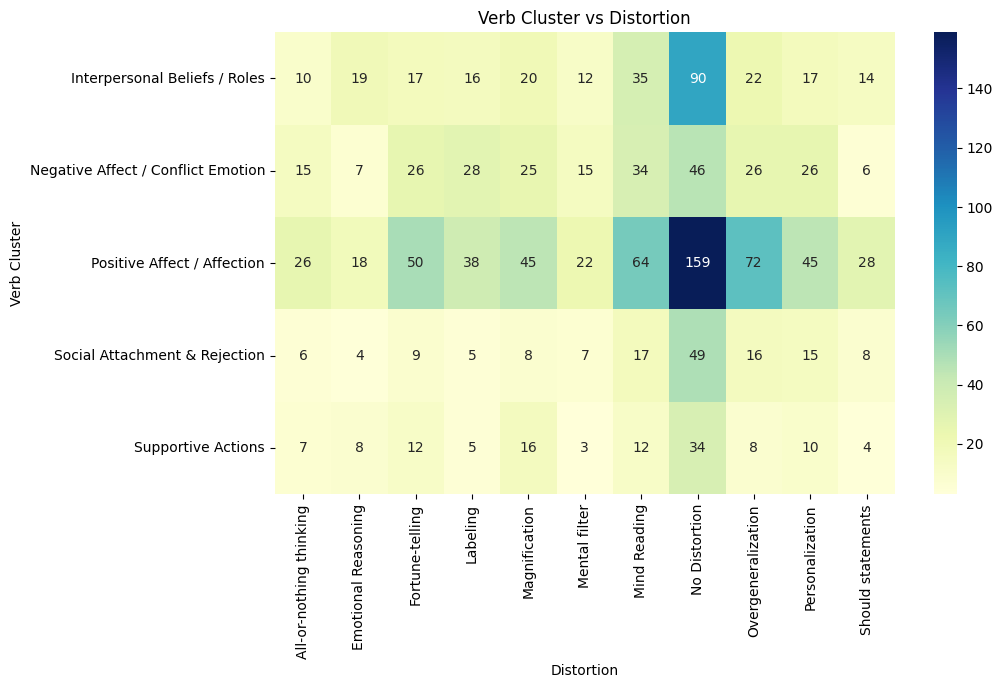

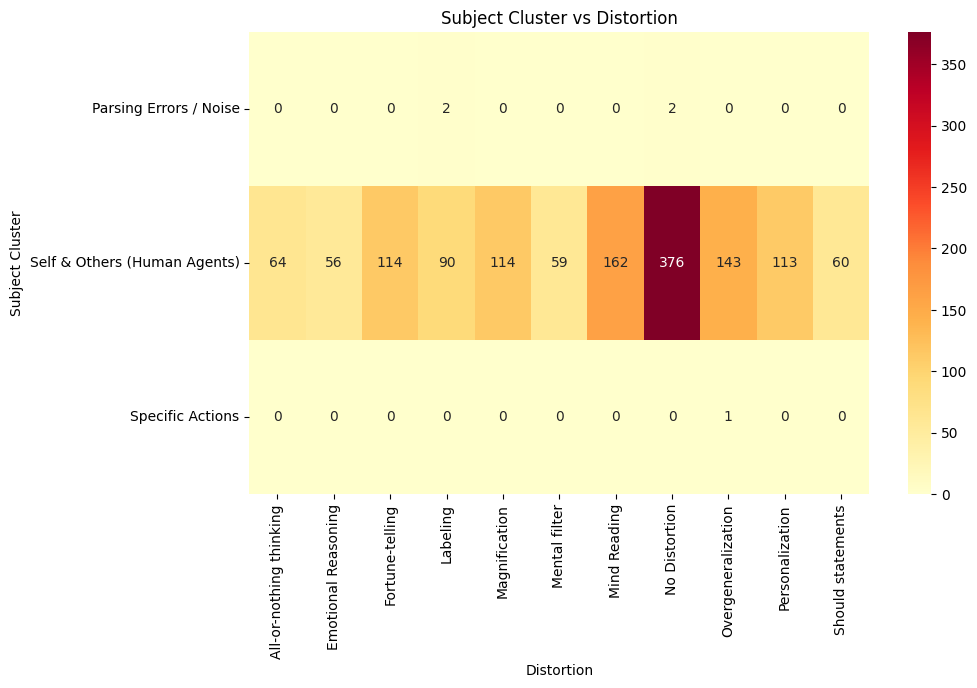

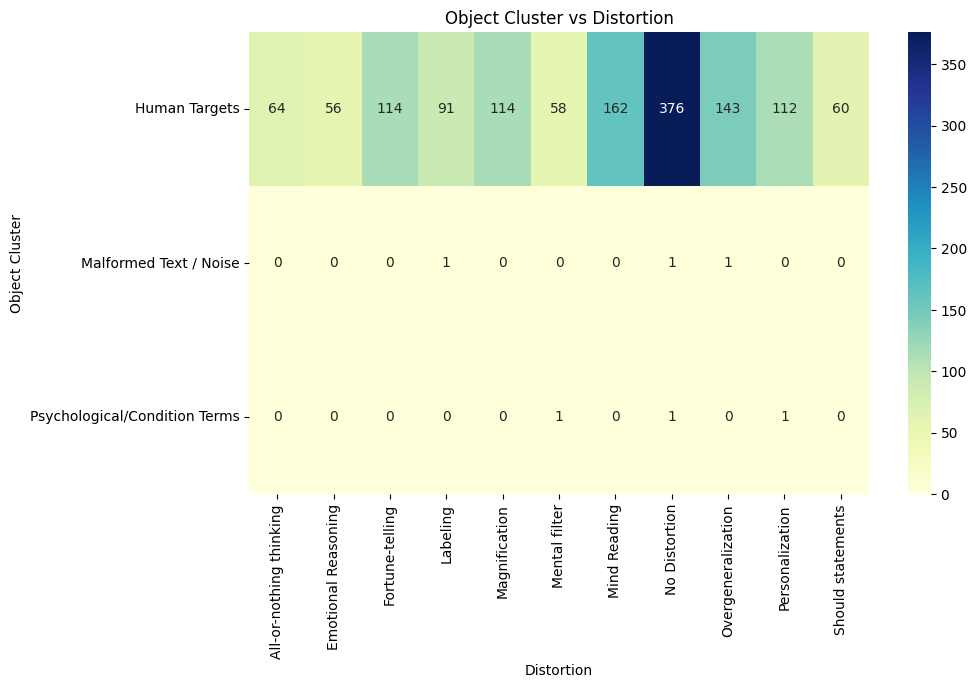

In [7]:
# Verb cluster × distortion
verb_dist_matrix = pd.crosstab(triples_df["verb_cluster_label"], triples_df["Dominant Distortion"])

plt.figure(figsize=(10,6))
sns.heatmap(verb_dist_matrix, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Verb Cluster vs Distortion")
plt.ylabel("Verb Cluster")
plt.xlabel("Distortion")
plt.show()

# Subject cluster × distortion
subj_dist_matrix = pd.crosstab(triples_df["subject_cluster_label"], triples_df["Dominant Distortion"])

plt.figure(figsize=(10,6))
sns.heatmap(subj_dist_matrix, cmap="YlOrRd", annot=True, fmt='d')
plt.title("Subject Cluster vs Distortion")
plt.ylabel("Subject Cluster")
plt.xlabel("Distortion")
plt.show()

# Object cluster × distortion
obj_dist_matrix = pd.crosstab(triples_df["object_cluster_label"], triples_df["Dominant Distortion"])

plt.figure(figsize=(10,6))
sns.heatmap(obj_dist_matrix, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Object Cluster vs Distortion")
plt.ylabel("Object Cluster")
plt.xlabel("Distortion")
plt.show()

####  Correlation Measures

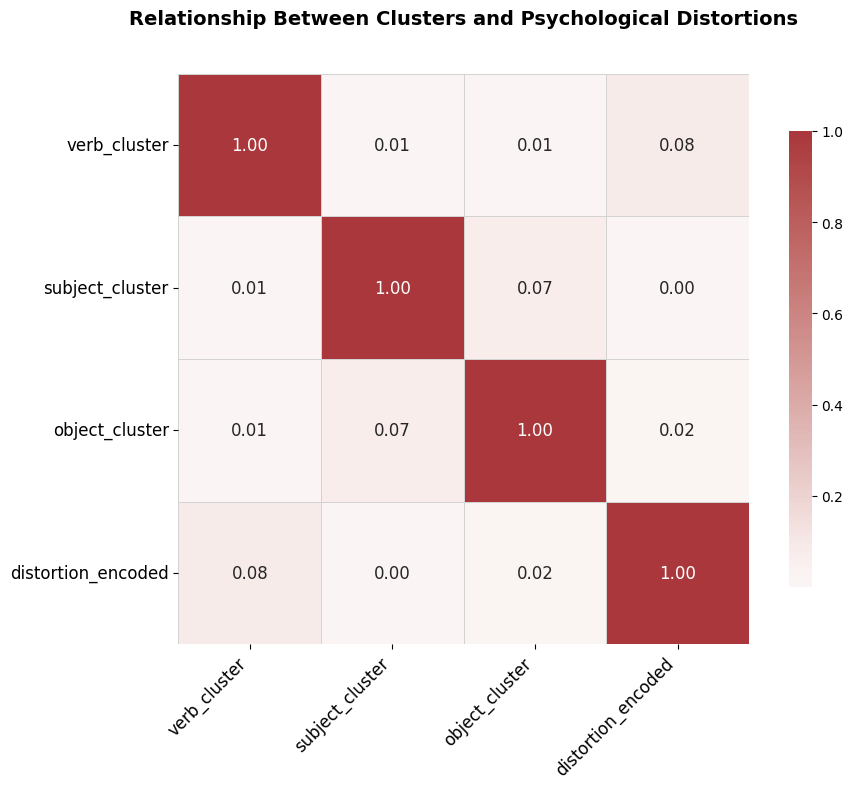

In [8]:
triples_df["Dominant Distortion"] = triples_df["Dominant Distortion"].fillna("No Distortion").astype(str)

# Encoding Dominant Distortion as categorical integer
distortion_encoder = LabelEncoder()
triples_df["distortion_encoded"] = distortion_encoder.fit_transform(triples_df["Dominant Distortion"])

# Map to numeric features
features = ["verb_cluster", "subject_cluster", "object_cluster", "distortion_encoded"]
corr_matrix = triples_df[features].corr(method='pearson')

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, annot=True,
    fmt=".2f", cmap="vlag",
    center=0, square=True,
    linewidths=0.5, linecolor='lightgray',
    cbar_kws={"shrink": 0.8}, annot_kws={"size": 12}
)

plt.title(
    "Relationship Between Clusters and Psychological Distortions\n",
    fontsize=14, pad=20, fontweight='bold'
)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

**Correlation Matrix:**

The correlation matrix shows the Pearson correlation coefficients between the verb, subject, and object clusters, and the encoded psychological distortion.

*   There is a small positive correlation (0.08) between the **verb cluster** and the **psychological distortion**. This suggests a weak tendency for certain verb types to be associated with the presence of psychological distortions.
*   The correlations between the **subject cluster** and distortion (0.00045), and the **object cluster** and distortion (0.019), are very close to zero, indicating a negligible linear relationship between these clusters and the presence of psychological distortions.
*   The correlations among the verb, subject, and object clusters are also very low, suggesting that these cluster types are largely independent of each other in the context of this dataset.

Overall, the correlation analysis suggests that, among the clusters examined, the verb cluster shows the weakest but most notable relationship with the presence of psychological distortions. However, the overall correlations are quite low, indicating that these clusters alone are not strong predictors of psychological distortions.

### measuring agreement between your verb clusters and distortion categories (Krippendorff’s Alpha)

In [9]:
!pip install krippendorff --quiet
import krippendorff
import numpy as np
import pandas as pd

# 1. Prepare Data Matrix
def prepare_reliability_matrix(df, row_col, col_col):
    """Convert dataframe to Krippendorff's reliability matrix"""
    # Pivot to item-by-rater matrix
    pivot_df = df.pivot_table(
        index=row_col,
        columns=col_col,
        aggfunc='size',
        fill_value=0
    ).reset_index(drop=True)

    # Convert to numpy array and transpose (items as columns)
    return pivot_df.values.T

# 2. Calculate Krippendorff's Alpha with Validation
try:
    # Prepare matrix (verbs as items, distortions as raters)
    reliability_data = prepare_reliability_matrix(
        triples_df,
        row_col="verb_cluster",
        col_col="Dominant Distortion"
    )

    # Check matrix requirements
    if reliability_data.shape[0] < 2 or reliability_data.shape[1] < 2:
        raise ValueError("Need ≥2 verb clusters and ≥2 distortion types")

    # Calculate alpha for nominal data
    alpha = krippendorff.alpha(
        reliability_data=reliability_data,
        level_of_measurement='nominal'
    )

    # 3. Enhanced Results Presentation
    print("\n Krippendorff's Alpha Reliability Analysis")
    print("="*50)
    print(f"{'Subjects (Verb Clusters):':<25} {reliability_data.shape[1]:,}")
    print(f"{'Raters (Distortion Types):':<25} {reliability_data.shape[0]:,}")
    print(f"{'Alpha Reliability Score:':<25} {alpha:.3f}")

    print("\nInterpretation Guide:")
    print("-"*50)
    print("| {:<8} | {:<36} |".format("α ≥ 0.80", "Excellent Reliability"))
    print("| {:<8} | {:<36} |".format("0.67 ≤ α < 0.80", "Good Reliability"))
    print("| {:<8} | {:<36} |".format("0.50 ≤ α < 0.67", "Marginal Reliability"))
    print("| {:<8} | {:<36} |".format("α < 0.50", "Unacceptable Reliability"))
    print("-"*50)

    # Show data snippet
    print("\nTop 5 Rows of Reliability Matrix:")
    print(pd.DataFrame(reliability_data.T).head())

except Exception as e:
    print(f"\n Analysis Failed: {str(e)}")
    print("\nTroubleshooting Tips:")
    print("- Ensure ≥2 verb clusters and ≥2 distortion types exist")
    print("- Check for null values in your columns")
    print("- Try reducing categories if some are very rare")


 Krippendorff's Alpha Reliability Analysis
Subjects (Verb Clusters): 5
Raters (Distortion Types): 11
Alpha Reliability Score:  0.010

Interpretation Guide:
--------------------------------------------------
| α ≥ 0.80 | Excellent Reliability                |
| 0.67 ≤ α < 0.80 | Good Reliability                     |
| 0.50 ≤ α < 0.67 | Marginal Reliability                 |
| α < 0.50 | Unacceptable Reliability             |
--------------------------------------------------

Top 5 Rows of Reliability Matrix:
   0   1   2   3   4   5   6    7   8   9   10
0  15   7  26  28  25  15  34  165  26  26   6
1   7   8  12   5  16   3  12   85   8  10   4
2  26  18  50  38  45  22  64  432  72  45  28
3  10  19  17  16  20  12  35  259  22  17  14
4   6   4   9   5   8   7  17  127  16  15   8


#### Co-occurrence Network Graph

/tmp/ipython-input-10-2444911793.py:41: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


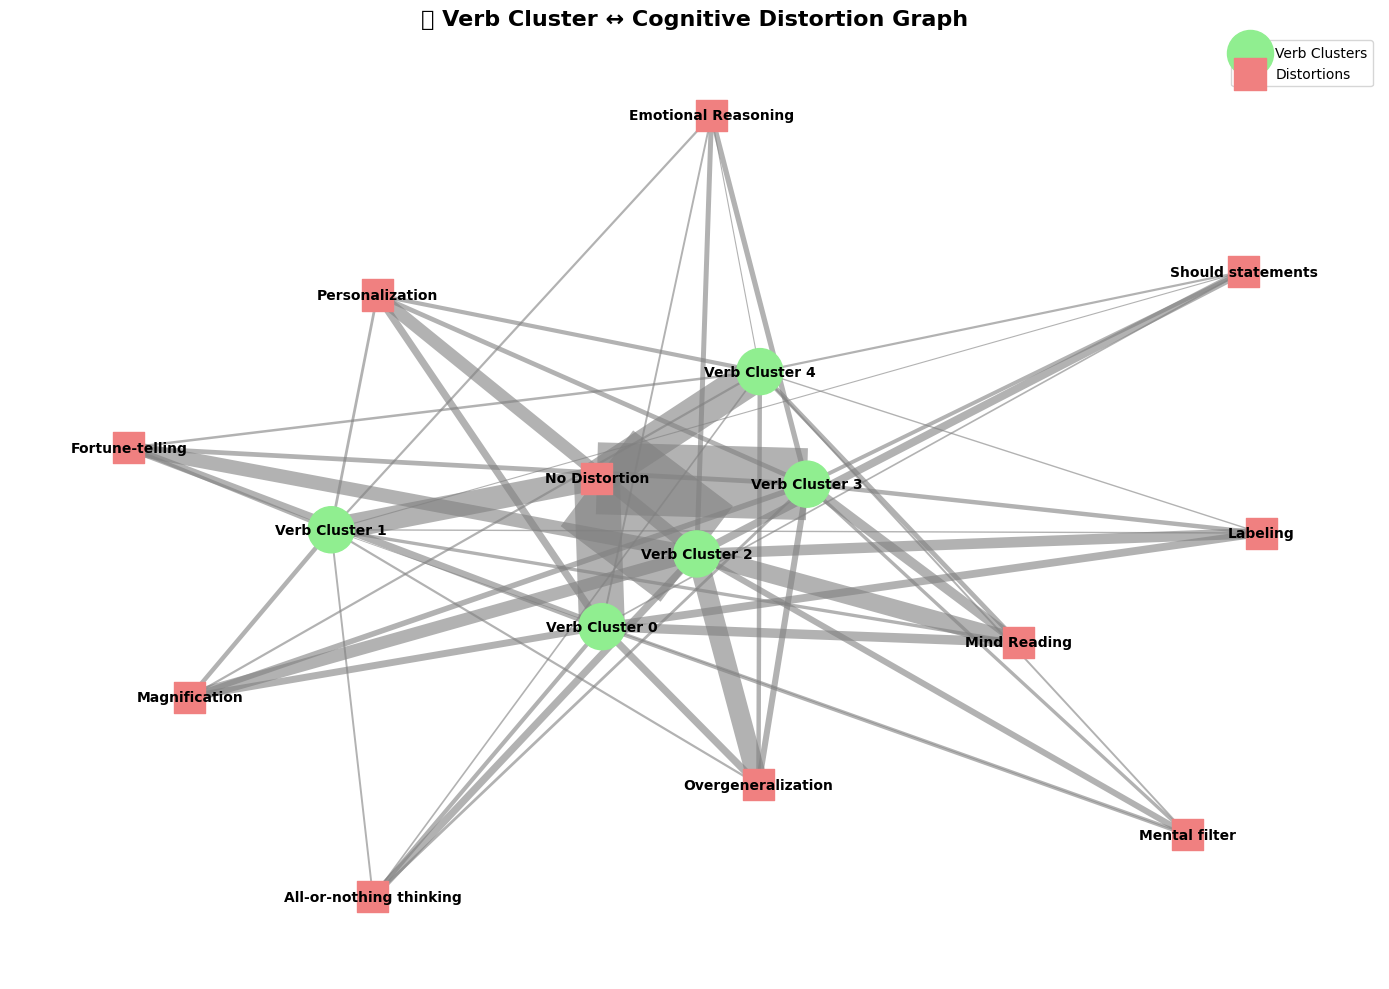

 Network Metrics:
- Nodes: 16 (Verb clusters: 5, Distortions: 11)
- Edges: 55 unique connections
- Density: 0.458 (sparsity = 0.542)

Most connected verb clusters:
- Verb Cluster 2: connected to 11 distortions
- Verb Cluster 0: connected to 11 distortions
- Verb Cluster 4: connected to 11 distortions
- Verb Cluster 3: connected to 11 distortions
- Verb Cluster 1: connected to 11 distortions


In [10]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Count frequencies for weighted edges
edge_counts = Counter()
for _, row in triples_df.iterrows():
    verb = f"Verb Cluster {row['verb_cluster']}"
    dist = row["Dominant Distortion"]
    edge_counts[(verb, dist)] += 1

# Create graph and add weighted edges
G = nx.Graph()
for (verb, dist), weight in edge_counts.items():
    G.add_edge(verb, dist, weight=weight)

# Determine node types
verb_nodes = [n for n in G.nodes() if 'Verb Cluster' in n]
distortion_nodes = [n for n in G.nodes() if 'Verb Cluster' not in n]

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.45, seed=42)

node_degrees = dict(G.degree())
verb_node_sizes = [node_degrees[node] * 100 for node in verb_nodes]
distortion_node_sizes = [node_degrees[node] * 100 for node in distortion_nodes]


# Draw nodes with different colors, shapes, and sizes
nx.draw_networkx_nodes(G, pos, nodelist=verb_nodes, node_color="lightgreen", node_size=verb_node_sizes, label="Verb Clusters", node_shape='o') # Circles for verb clusters
nx.draw_networkx_nodes(G, pos, nodelist=distortion_nodes, node_color="lightcoral", node_size=distortion_node_sizes, label="Distortions", node_shape='s') # Squares for distortions

weights = [G[u][v]["weight"] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=[w * 0.2 for w in weights], edge_color="gray", alpha=0.6) # Reduced width multiplier

nx.draw_networkx_labels(G, pos, font_size=10, font_color="black", font_weight="bold")

plt.title("🔗 Verb Cluster ↔ Cognitive Distortion Graph", fontsize=16, fontweight="bold")
plt.legend(scatterpoints=1, loc="best")
plt.axis("off")
plt.tight_layout()
plt.show()

print(f" Network Metrics:")
print(f"- Nodes: {G.number_of_nodes()} (Verb clusters: {len(verb_nodes)}, Distortions: {len(distortion_nodes)})")
print(f"- Edges: {G.number_of_edges()} unique connections")
print(f"- Density: {nx.density(G):.3f} (sparsity = {1 - nx.density(G):.3f})")
print("\nMost connected verb clusters:")
for node, degree in sorted(G.degree(), key=lambda x: x[1], reverse=True):
    if 'Verb Cluster' in node:
        print(f"- {node}: connected to {degree} distortions")

#### Pair Plots

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


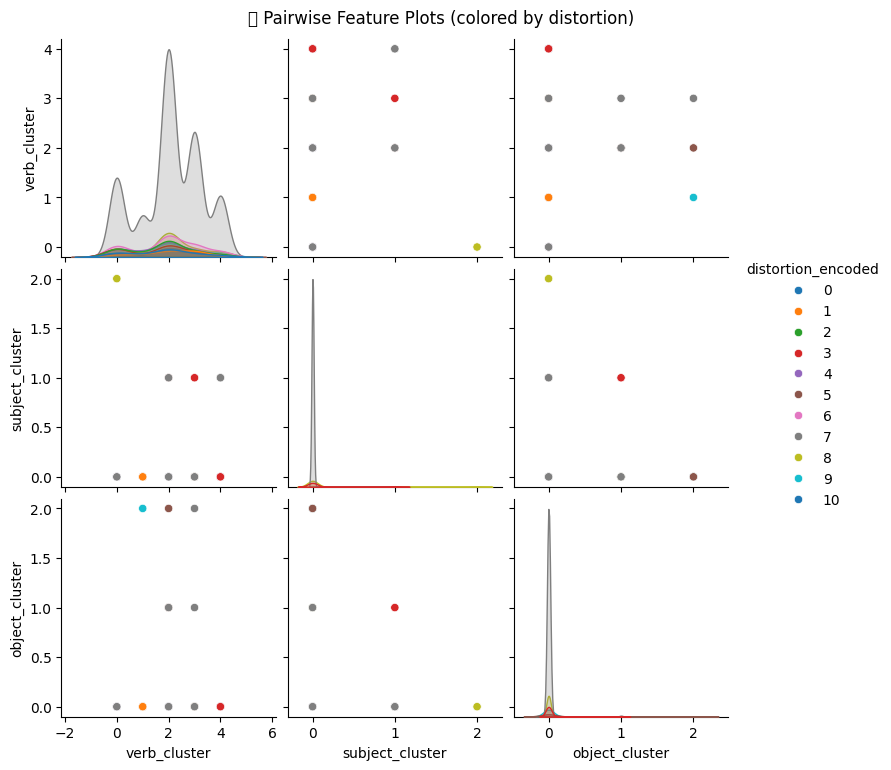

In [11]:
import seaborn as sns

sns.pairplot(triples_df[["verb_cluster", "subject_cluster", "object_cluster", "distortion_encoded"]],
             hue="distortion_encoded", palette="tab10", diag_kind="kde")
plt.suptitle("🔍 Pairwise Feature Plots (colored by distortion)", y=1.02)
plt.show()

#### Summary Report

In [12]:
from scipy.stats import pearsonr

# Pearson R & p-value for each cluster vs distortion
for col in ["verb_cluster", "subject_cluster", "object_cluster"]:
    r, p = pearsonr(triples_df[col], triples_df["distortion_encoded"])
    print(f"{col} ↔ distortion_encoded: Pearson r = {r:.3f}, p = {p:.4f}")


verb_cluster ↔ distortion_encoded: Pearson r = 0.081, p = 0.0002
subject_cluster ↔ distortion_encoded: Pearson r = 0.000, p = 0.9838
object_cluster ↔ distortion_encoded: Pearson r = 0.019, p = 0.3934


## Creating Subclusters for Verb Clusters with Distortion Counts

In [13]:
import pandas as pd

# Assuming triples_df is your DataFrame
# First, we'll create a combined distortion column that includes both dominant and secondary distortions
distortion_cols = ['Dominant Distortion', 'Secondary Distortion (Optional)']
triples_df['All Distortions'] = triples_df[distortion_cols].apply(lambda x: [d for d in x if pd.notna(d)], axis=1)

# Explode the list of distortions so each distortion gets its own row
exploded_df = triples_df.explode('All Distortions')

# Create the crosstab between verbs and distortions
distortion_counts = pd.crosstab(
    index=exploded_df['verb'],
    columns=exploded_df['All Distortions'],
    margins=False  # Don't include row/column totals
)

# Add a column for non-distorted cases (where distortion is empty)
# First get all rows where both distortion columns are NaN
non_distorted = triples_df[triples_df[distortion_cols].isna().all(axis=1)]
non_distorted_counts = non_distorted['verb'].value_counts().rename('No Distortion')

verb_subclusters = distortion_counts.join(non_distorted_counts, how='outer', lsuffix='_dist', rsuffix='_no_dist').fillna(0)

# Convert counts to integers
verb_subclusters = verb_subclusters.astype(int)
verb_subclusters.head(10)

,All-or-nothing thinking,Emotional Reasoning,Fortune-telling,Labeling,Magnification,Mental filter,Mind Reading,No Distortion_dist,Overgeneralization,Personalization,Should statements,No Distortion_no_dist
verb,,,,,,,,,,,,
abandon,0,0,1,0,0,0,3,7,2,1,1,0
abuse,2,2,5,4,1,1,3,40,3,2,2,0
accept,3,1,2,5,3,2,7,27,6,9,3,0
accuse,1,1,0,1,0,1,2,17,3,3,0,0
admire,0,0,0,0,0,0,0,4,0,0,0,0
avoid,4,4,3,0,3,2,6,27,5,0,0,0
befriend,0,0,0,0,0,0,0,4,0,0,0,0
believe,4,6,9,5,4,2,12,37,6,7,2,0
betray,0,0,1,0,0,0,0,0,0,1,1,0


In [14]:
verb_subclusters.to_csv('/content/drive/MyDrive/My Research/verb_subclusters.csv')
print("verb_subclusters saved to Google Drive.")

verb_subclusters saved to Google Drive.
